# Group Splitter Validation

Load a trained group splitter model and generate validation plots:
- Load model from checkpoint
- Load validation data
- Generate predictions
- Create evaluation plots (confusion matrices, ROC curves, precision-recall, probability distributions)

In [ ]:
import json
import torch
import numpy as np
from pathlib import Path
from datetime import datetime
from typing import Optional

from pioneerml.zenml import utils as zenml_utils
from pioneerml.metadata import MetadataManager
from pioneerml.data import NODE_LABEL_TO_NAME, NUM_NODE_CLASSES
from pioneerml.data.loaders import load_splitter_groups
from pioneerml.training.datamodules import SplitterDataModule
from pioneerml.evaluation.plots import (
    plot_multilabel_confusion_matrix,
    plot_precision_recall_curves,
    plot_roc_curves,
    plot_probability_distributions,
    plot_confidence_analysis,
)

PROJECT_ROOT = zenml_utils.find_project_root()
metadata_manager = MetadataManager(root=PROJECT_ROOT)

print(f"Project root: {PROJECT_ROOT}")


Project root: /home/jack/python_projects/pioneerML


## List Available Checkpoints

Find all saved model checkpoints and their metadata files.


In [ ]:
# List and print all available checkpoints
checkpoints = metadata_manager.print_checkpoints("GroupSplitter")

# Select most recent checkpoint (index 0)
if not checkpoints:
    raise ValueError("No checkpoints found for GroupSplitter")

print(f"\nUsing checkpoint: {checkpoints[0]['checkpoint_path'].name}")


Found 1 checkpoint(s):
  1. groupsplitter_20251207_193129_group_splitter_optuna_pipeline-2025_12_07-19_30_15_976540_state_dict.pt
     Timestamp:     20251207_193129
     Run:           group_splitter_optuna_pipeline-2025_12_07-19_30_15_976540
     Architecture:  hidden=192, heads=7, layers=4, dropout=0.09902375280917053

Using checkpoint: groupsplitter_20251207_193129_group_splitter_optuna_pipeline-2025_12_07-19_30_15_976540_state_dict.pt


## Load Model

Reconstruct the model architecture from metadata and load the saved weights.


In [ ]:
# Load model using MetadataManager (uses most recent checkpoint by default, index=0)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model, metadata = metadata_manager.load_model(
    "GroupSplitter",
    index=0,  # Use most recent checkpoint
    device=device,
)

print(f"\nModel loaded successfully on {device}")
print(f"  Checkpoint: {checkpoints[0]['checkpoint_path'].name}")
print(f"  Timestamp: {metadata.timestamp}")
print(f"  Run: {metadata.run_name or 'unknown'}")
print(f"  Parameters: {sum(p.numel() for p in model.parameters()):,}")



Model loaded successfully on cuda
  Checkpoint: groupsplitter_20251207_193129_group_splitter_optuna_pipeline-2025_12_07-19_30_15_976540_state_dict.pt
  Timestamp: 20251207_193129
  Run: group_splitter_optuna_pipeline-2025_12_07-19_30_15_976540
  Parameters: 1,731,432


## Load Validation Data

Load the same data pattern used during training (or a subset for faster validation).


In [4]:
# Load validation data
# Use the same file pattern as training: mainTimeGroups_*.npy
file_pattern = str(Path(PROJECT_ROOT) / "data" / "mainTimeGroups_*.npy")

# For validation, use full available data (no limiting by default)
validation_groups = load_splitter_groups(
    file_pattern,
    max_files=1,
    limit_groups=None,
    min_hits=3,
    verbose=True,
)

print(f"Loaded {len(validation_groups)} groups for validation")

# Create datamodule
# val_split=0.0 means we use the full set (train split) for evaluation here
datamodule = SplitterDataModule(
    records=validation_groups,
    batch_size=128,
    num_workers=0,  # Set to 0 for validation to avoid multiprocessing issues
    val_split=0.0,
    test_split=0.0,
    seed=42,
)
datamodule.setup(stage="fit")

val_dataset = datamodule.val_dataset or datamodule.train_dataset
if val_dataset is None:
    raise ValueError("No validation dataset available")

print(f"Validation dataset size: {len(val_dataset)}")


Limiting to 1 files (from 11 total files found, max_files=1)


Loaded 777 splitter groups from 1 files; pion_hits=284524, muon_hits=61120, mip_hits=386226, total_hits=731870
Loaded 777 groups for validation
Validation dataset size: 777


## Generate Predictions

Run inference on the validation dataset.


In [5]:
from torch_geometric.loader import DataLoader

# Create dataloader
val_loader = DataLoader(val_dataset, batch_size=128, shuffle=False, num_workers=0)

# Generate predictions
all_predictions = []
all_targets = []

model.eval()
with torch.no_grad():
    for batch in val_loader:
        batch = batch.to(device)
        preds = model(batch)
        all_predictions.append(preds.cpu())
        all_targets.append(batch.y.cpu())

# Concatenate all predictions and targets
predictions = torch.cat(all_predictions, dim=0)
targets = torch.cat(all_targets, dim=0)

print(f"Generated predictions:")
print(f"  Predictions shape: {predictions.shape}")
print(f"  Targets shape: {targets.shape}")
print(f"  Predictions range: [{predictions.min():.4f}, {predictions.max():.4f}]")


Generated predictions:
  Predictions shape: torch.Size([24840, 3])
  Targets shape: torch.Size([24840, 3])
  Predictions range: [-17.0155, 12.5530]


## Generate Validation Plots

Create comprehensive evaluation plots to assess model performance.


In [6]:
# Create output directory for plots
plots_dir = Path(PROJECT_ROOT) / "artifacts" / "validation_plots" / "group_splitter"
plots_dir.mkdir(parents=True, exist_ok=True)

timestamp_str = metadata.timestamp if metadata else datetime.now().strftime("%Y%m%d_%H%M%S")
plot_prefix = f"group_splitter_{timestamp_str}"

# Get class names from metadata or use defaults
dataset_info = metadata.dataset_info or {} if metadata else {}
class_names = dataset_info.get("class_names", list(NODE_LABEL_TO_NAME.values()))

print(f"Generating validation plots in: {plots_dir}")
print(f"Class names: {class_names}")


Generating validation plots in: /home/jack/python_projects/pioneerML/artifacts/validation_plots/group_splitter
Class names: ['pion', 'muon', 'mip']


### Confusion Matrix

The confusion matrix shows how well the model classifies each hit type. It displays the true labels vs predicted labels in a grid format.

**How to interpret:**
- **Diagonal elements** (top-left to bottom-right): Correct predictions. Higher values indicate better performance for that class.
- **Off-diagonal elements**: Misclassifications. Shows which classes are being confused with each other.
- **Normalized values**: Percentages show the proportion of each true class that was predicted as each class. A perfect classifier would have 100% on the diagonal and 0% elsewhere.

**What to look for:**
- High diagonal values indicate good classification
- Off-diagonal patterns reveal systematic confusions



1. Generating confusion matrices...


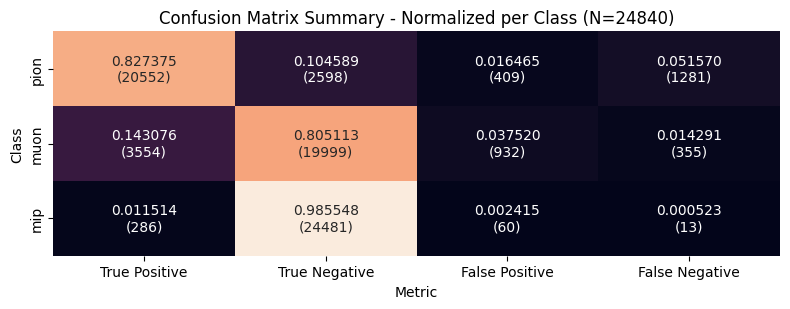

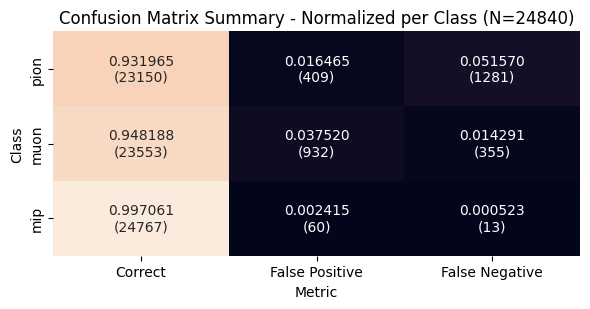

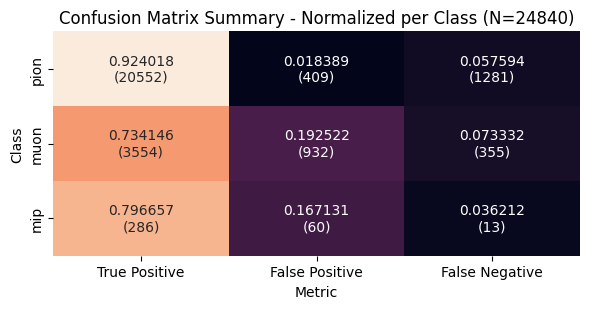

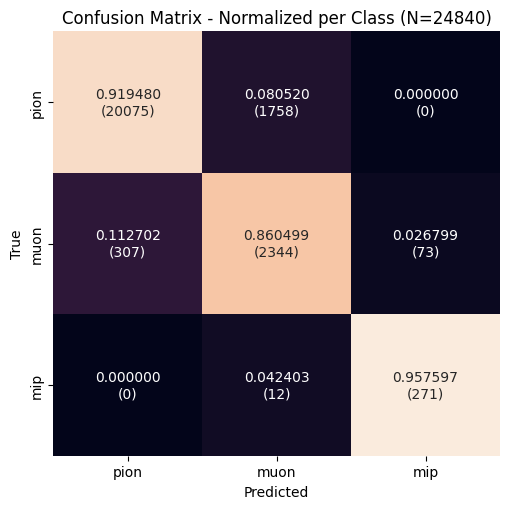

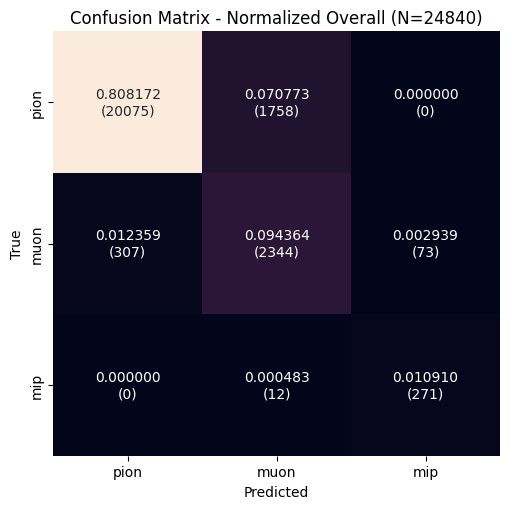

In [7]:
# 1. Confusion Matrix

print("\n1. Generating confusion matrices...")

# Default summary mode (4 columns: TP, TN, FP, FN)
plot_multilabel_confusion_matrix(
    predictions=predictions,
    targets=targets,
    class_names=class_names,
    precision=6,
    view_mode="summary",
    summary_mode="default",
    threshold=0.5,
    normalize=True,
    show=True,
)

# Correct mode summary (3 columns: Correct, FP, FN)
plot_multilabel_confusion_matrix(
    predictions=predictions,
    targets=targets,
    class_names=class_names,
    precision=6,
    view_mode="summary",
    summary_mode="correct_mode",
    threshold=0.5,
    normalize=True,
    show=True,
)

# True positive mode summary (3 columns: TP, FP, FN, excludes TN)
plot_multilabel_confusion_matrix(
    predictions=predictions,
    targets=targets,
    class_names=class_names,
    precision=6,
    view_mode="summary",
    summary_mode="true_positive_mode",
    threshold=0.5,
    normalize=True,
    show=True,
)

# nxn view - normalized per class
plot_multilabel_confusion_matrix(
    predictions=predictions,
    targets=targets,
    class_names=class_names,
    precision=6,
    view_mode="nxn",
    normalize_mode="row",
    threshold=0.5,
    normalize=True,
    show=True,
)

# nxn view - normalized overall
plot_multilabel_confusion_matrix(
    predictions=predictions,
    targets=targets,
    class_names=class_names,
    precision=6,
    view_mode="nxn",
    threshold=0.5,
    normalize=True,
    show=True,
)


### ROC Curves (Receiver Operating Characteristic)

ROC curves show the trade-off between the true positive rate (sensitivity) and false positive rate (1 - specificity) at different classification thresholds.

**How to interpret:**
- **X-axis (False Positive Rate)**: Proportion of negative samples incorrectly classified as positive. Lower is better.
- **Y-axis (True Positive Rate / Recall)**: Proportion of positive samples correctly identified. Higher is better.
- **Diagonal line (AUC = 0.5)**: Random guessing baseline. Any curve above this indicates the model is learning.
- **AUC (Area Under Curve)**: Higher values mean the model can better distinguish between classes.

**What to look for:**
- Curves that hug the top-left corner indicate better performance
- Higher AUC values mean the model can better distinguish between classes



2. Generating ROC curves...


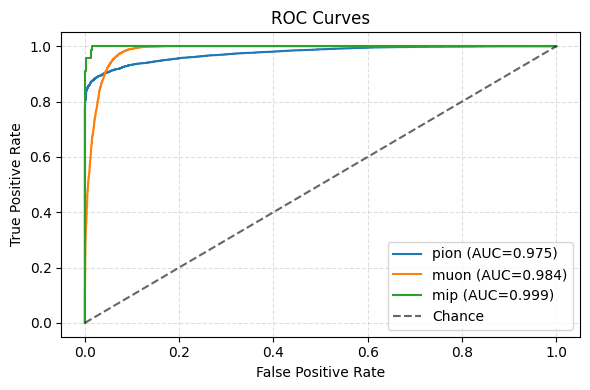

In [8]:
# 2. ROC Curves
print("\n2. Generating ROC curves...")
plot_roc_curves(
    predictions=predictions,
    targets=targets,
    class_names=class_names,
    show=True,
)


### Precision-Recall Curves

Precision-Recall curves show the relationship between precision (accuracy of positive predictions) and recall (coverage of positive samples) at different thresholds.

**How to interpret:**
- **X-axis (Recall)**: Proportion of actual positives that were correctly identified. Also called sensitivity or true positive rate.
- **Y-axis (Precision)**: Proportion of predicted positives that are actually positive. Measures prediction quality.
- **AP (Average Precision)**: The area under the PR curve. Higher values indicate better performance.

**What to look for:**
- Curves that stay high on the Y-axis (high precision) indicate confident, accurate predictions
- Curves that extend far right (high recall) mean the model finds most positive samples
- **Precision-Recall vs ROC**: PR curves are more informative than ROC when classes are imbalanced



3. Generating precision-recall curves...


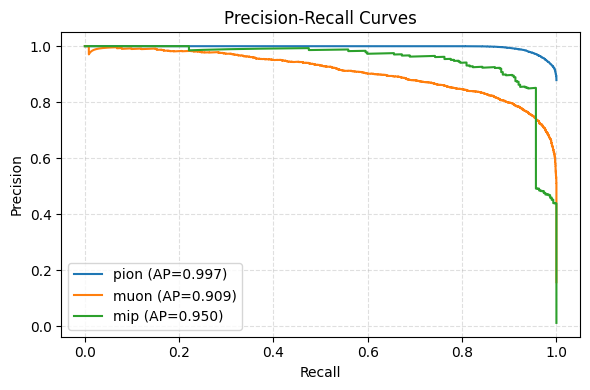

In [9]:
# 3. Precision-Recall Curves
print("\n3. Generating precision-recall curves...")
plot_precision_recall_curves(
    predictions=predictions,
    targets=targets,
    class_names=class_names,
    show=True,
)


### Probability Distributions

Show how well separated the probability distributions are for each class. These plots display the predicted probabilities (after softmax) for each hit type.

**How to interpret:**
- **Probability values**: After applying softmax, predictions are converted to probabilities (0-1).
- **Histogram shape**: 
  - Sharp peak near 1.0 for correct class = confident, accurate predictions
  - Broad distribution = uncertain predictions
  - Peak near 0.0 for incorrect classes = good discrimination

**What to look for:**
- Strong peaks at high probability for the correct class indicate confident, accurate predictions
- Low probabilities for incorrect classes show good discrimination



4. Generating probability distribution plots...


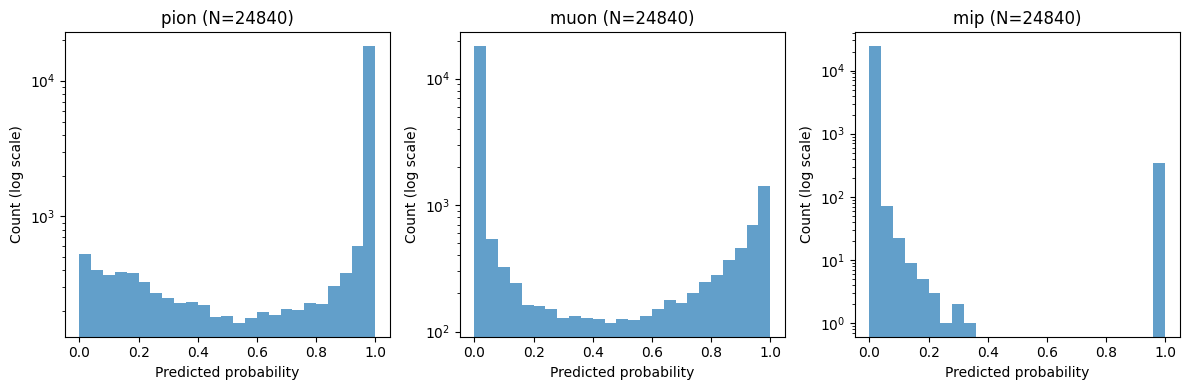

In [10]:
# 4. Probability Distributions
print("\n4. Generating probability distribution plots...")
plot_probability_distributions(
    predictions=predictions,
    targets=targets,
    class_names=class_names,
    show=True,
)


### Confidence Analysis

Analyze the model's confidence in its predictions across different classes and prediction thresholds.

**How to interpret:**
- Shows how confident the model is in its predictions
- Helps identify where the model is uncertain
- Can reveal calibration issues

**What to look for:**
- High confidence for correct predictions indicates good calibration
- Low confidence for incorrect predictions shows the model knows when it's uncertain



5. Generating confidence analysis plots...


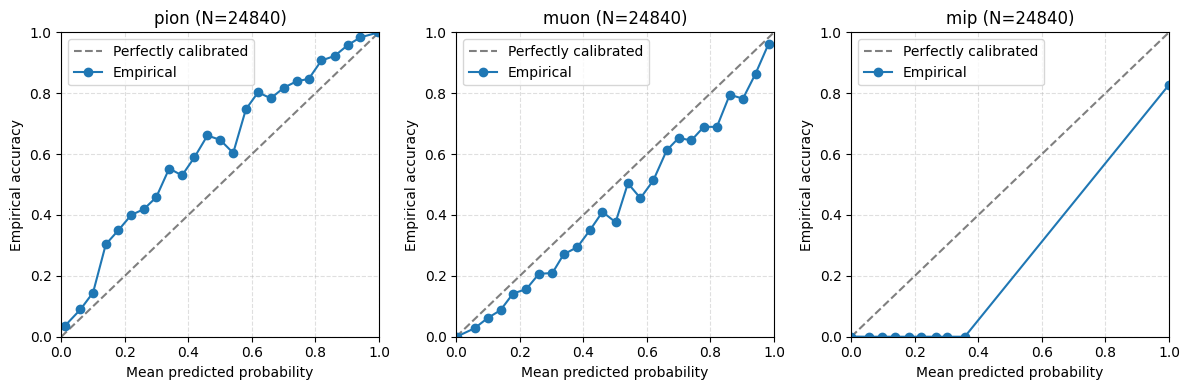

In [11]:
# 5. Confidence Analysis
print("\n5. Generating confidence analysis plots...")
plot_confidence_analysis(
    predictions=predictions,
    targets=targets,
    class_names=class_names,
    show=True,
)
